In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype
from skimage import io
from pathlib import Path

import bezier

from sklearn.preprocessing import minmax_scale
from skimage import feature
from genpen.utils import Paper

from scipy import spatial, stats
from scipy.ndimage import gaussian_filter
from scipy.integrate import odeint
from scipy.signal import decimate

In [20]:
# make page
paper_size = '11x17 inches'
border:float=35
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)
layers = []

In [21]:
prms = gp.NuzzleParams()
prms.dilate_multiplier_max=0.15
prms.dilate_cap_style = 2
prms.dilate_join_style = 2
prms.erode_cap_style = 2
prms.erode_join_style =2

In [28]:
min_rad = 1.5
iter_max = 50

In [23]:
all_circles = []
circle_to_fill = drawbox


In [31]:
n_fails = 0
n_iters = 0
while (n_fails < 10) and (n_iters < iter_max):
    try:
        n_iters += 1
        fc_rad = gp.get_rad(circle_to_fill)
        rads = np.linspace(fc_rad*0.5, fc_rad*0.07, 15)
        rads[rads<min_rad] = min_rad
        circles = gp.circle_pack_within_poly(circle_to_fill, rads, progress_bar=False)
        if circles.type == 'MultiPolygon':
            circles =gp.nuzzle_em(circles, prms, n_iters=20)
            circle_to_fill.filled = True
            circles = circles.intersection(circle_to_fill)
            all_circles += [c.buffer(-0.) for c in circles]
        not_yet_filled = [c for c in all_circles if not getattr(c, 'filled', False)]
        areas = np.array([c.area for c in not_yet_filled])
        areas = areas/areas.sum()
        circle_to_fill = np.random.choice(not_yet_filled, p=areas)
        n_fails = 0
    except:
        n_fails += 1
MultiPolygon(all_circles).boundary

In [35]:
bottom_level_circles = [c for c in all_circles if not getattr(c, 'filled', False)]

In [48]:
blcb = MultiPolygon(bottom_level_circles).buffer(-0.5).boundary

In [54]:
fill_circles = []
for c in all_circles:
    if not getattr(c, 'filled', False):
        
        rad = gp.get_rad(c)
        if rad > 0.5:
            _c = c.buffer(-0.5)
            spacing = np.random.uniform(-0.5, -0.51)
            erodes = np.arange(spacing, -rad+0.5, spacing)
    #         erodes *= (np.random.randn(*erodes.shape) * 0.01 + 1)
            fill_circles += [_c.buffer(b) for b in erodes]

fills = MultiPolygon(fill_circles).boundary

In [55]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('1mm')



sk.stroke(1)
sk.geometry(blcb)
sk.stroke(2)
sk.geometry(fills)

for tol in [0.1]:
    sk.vpype(f'linesimplify -t {tol}mm linemerge -t {tol}mm')

sk.vpype('linesort')

sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-31T00:45:53.468687 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polygon points="850.7543,532.3243 851.2668,525.0072 852.8414,519.5149 851.91,516.0405 852.4379,514.0832 850.6677,510.9714 857.5292,504.7506 865.4412,501.0085 874.7663,499.1502 875.9472,500.4188 883.2457,502.5555 883.9146,504.3079 886.5649,505.7205 887.4839,507.4732 892.271,511.3765 895.4158,515.1409 897.5225,516.2273 899.3281,518.9839 898.8515,522.8183 899.3284,526.4684 895.1875,531.785 893.6261,537.6535 894.1406,543.6821 892.8735,544.1477 887.3935,549.1691 884.2826,548.2151 880.4546,548.027 877.6424,548.5864 874.1777,550.225 869.7412,553.7359 867.4948,561.0628 866.0922,560.7114 866.4674,557.3674 865.7449,552.578 862.0013,547.407 858.3792,544.748 858.1334,542.6758 854.0758,534.8642"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polygon points="779.4349,306.1579 784.4704,307.5125 792.6416,308.299 800.6273,307.5125 807.8519,305.5639 817.3611,297.4998 825.8182,292.2631 829.523,286.082 832.5938,278.6685 834.2131,270.6208 834.4151,266.1537 844.9151,269.9107 854.705,272.3723 864.689,273.8625 871.0889,274.186 869.3267,278.6188 868.2149,284.3016 868.2331,290.0921 869.3267,295.5903 871.5259,300.9469 874.7278,305.7716 878.8094,309.8789 881.9852,312.1349 882.886,316.3906 884.8952,321.1526 876.1158,324.8401 863.26,333.7796 857.366,343.4548 852.4971,350.0807 849.906,360.3131 848.933,370.1919 849.1905,375.4324 851.1438,385.2233 846.44,387.538 845.8398,389.2155 846.8911,390.8498 843.1983,391.8122 842.137,393.2432 842.6061,394.7896 845.7532,397.1689 836.6766,400.5976 833.2179,400.3652 834.6477,395.1935 835.3845,387.5273 834.6115,379.8647 832.3585,372.5002 828.385,364.2891 819.6257,357.7476 812.5278,351.3634 803.6716,349.0706 796.0055,348.3338 784.7828,349.9985 777.4757,353.0291 775.3544,345.2019 774.0768,332.2303 775.3544,319.2586"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polygon points="719.1125,324.4903 716.9434,318.1138 717.9394,316.018 717.5278,309.5734 718.7728,304.6032 722.0468,299.2847 722.1955,298.1163 724.1405,296.7546 725.2428,296.6629 727.8688,300.4991 730.4262,300.3454 736.6483,302.4807 742.1464,302.0134 744.4534,302.8576 748.0762,300.3819 749.2768,300.8758 750.4953,300.5062 752.3985,296.1325 752.8115,296.5882 756.3066,302.4194 757.9585,309.0141 755.9628,320.877 754.5632,323.4922 752.5324,323.7154 749.7811,323.0969 743.1181,323.7552 737.4071,326.0845 733.4124,329.5725 731.0522,330.4085 730.271,331.3286 723.4624,328.4077"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polygon points="675.5068,444.617 677.7236,441.8608 676.4906,439.4782 676.2254,437.4264 677.3186,433.2512 676.9583,429.2887 677.634,424.6737 676.6685,420.2343 678.5456,415.6082 676.4746,412.9842 678.0059,411.4865 678.2528,410.23 685.0813,406.8379 689.592,405.9407 694.1912,405.9407 700.8697,407.6136 704.9258,409.7816 708.481,412.6993 712.5823,418.2292 714.3424,422.4783 715.3387,429.0063 714.3874,435.9193 707.2794,437.7091 699.3031,440.5728 691.6459,444.2044 681.8384,450.4553 677.0075,447.4236 676.779,446.0747"/>
 
 
 
 
 <polygon points="665.17,521.4121 669.4686,523.4351 670.7419,523.4351 672.1036,522.1337 677.6442,520.509 682.0333,516.7257 685.0952,516.4454 688.9585,515.0342 692.1147,512.6934 694.3179,509.8545 703.1191,513.0125 705.8894,514.888 710.8644,514.8194 714.6973,521.0562 714.5309,524.6284 715.6749,533.3582 716.9044,536.9022 716.3189,539.2398 709.2807,539.7296 708.0151,541.2215 706.1759,541.8293 705.0449,543.21 698.1995,547.7613 692.7454,544.4771 683.6653,543.9288 679.0293,545.6159 676.3916,544.8429 675.3329,545.5503 672.3411,550.5242 668.0152,539.8633 666.41,533.4548"/>
 
 <polygon points="697.4799,573.1295 699.3405,571.0371 701.8151,564.6438 701.8074,557.0126 700.8012,555.4282 705.2692,551.0584 713.0822,546.4324 715.2109,546.3278 719.3923,547.8618 721.6141,550.2997 725.2787,552.6468 727.7214,555.052 731.0503,556.9037 729.073,558.5493 727.2563,562.6387 727.0081,567.795 725.9441,571.2308 726

In [56]:
sk.save('/mnt/c/code/side/plotter_images/oned_outputs/258_any_shape_none_touch.svg')

# try 3

In [2]:
# make page
paper_size = '11x17 inches'
border:float=35
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)
layers = []

In [3]:
prms = gp.NuzzleParams()
prms.dilate_multiplier_max=0.15
prms.dilate_cap_style = 2
prms.dilate_join_style = 2
prms.erode_cap_style = 2
prms.erode_join_style =2

In [12]:
min_rad = 1.5
iter_max = 10

In [13]:
all_circles = []
circle_to_fill = drawbox


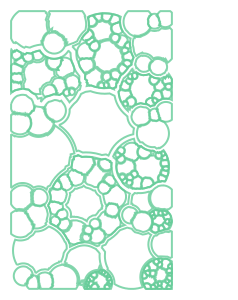

In [14]:
n_fails = 0
n_iters = 0
while (n_fails < 10) and (n_iters < iter_max):
    try:
        n_iters += 1
        fc_rad = gp.get_rad(circle_to_fill)
        rads = np.linspace(fc_rad*0.5, fc_rad*0.07, 15)
        rads[rads<min_rad] = min_rad
        circles = gp.circle_pack_within_poly(circle_to_fill, rads, progress_bar=False)
        if circles.type == 'MultiPolygon':
            circles =gp.nuzzle_em(circles, prms, n_iters=20)
            circle_to_fill.filled = True
            circles = circles.intersection(circle_to_fill)
            all_circles += [c.buffer(-0.) for c in circles]
        not_yet_filled = [c for c in all_circles if not getattr(c, 'filled', False)]
        areas = np.array([c.area for c in not_yet_filled])
        areas = areas/areas.sum()
        circle_to_fill = np.random.choice(not_yet_filled, p=areas)
        n_fails = 0
    except:
        n_fails += 1
MultiPolygon(all_circles).boundary

In [15]:
bottom_level_circles = [c for c in all_circles if not getattr(c, 'filled', False)]

In [16]:
blcb = MultiPolygon(bottom_level_circles).buffer(-0.5).boundary

In [17]:
fill_circles = []
for c in all_circles:
    if not getattr(c, 'filled', False):
        
        rad = gp.get_rad(c)
        if rad > 0.5:
            _c = c.buffer(-0.5)
            spacing = np.random.uniform(-0.5, -0.8)
            erodes = np.arange(spacing, -rad+0.5, spacing)
    #         erodes *= (np.random.randn(*erodes.shape) * 0.01 + 1)
            fill_circles += [_c.buffer(b) for b in erodes]

fills = MultiPolygon(fill_circles).boundary

In [18]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('1mm')



sk.stroke(1)
sk.geometry(blcb)
sk.stroke(2)
sk.geometry(fills)

for tol in [0.1]:
    sk.vpype(f'linesimplify -t {tol}mm linemerge -t {tol}mm')

sk.vpype('linesort')

sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-31T11:25:09.997725 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polygon points="842.7739,193.0976 843.5666,190.2692 842.7588,189.2849 841.2433,188.8214 843.0455,184.7264 846.8216,179.0414 847.5073,174.5518 848.0012,172.8926 849.698,171.1605 849.7284,169.1951 850.7646,169.0414 856.3812,172.8635 861.4532,174.134 867.9479,173.4943 872.8794,171.1069 875.6514,173.1175 886.1603,176.7709 887.4555,179.3189 893.1237,184.4244 893.2564,189.1897 895.556,195.8019 899.41,200.6521 898.8131,203.7594 895.4154,207.3672 891.9899,214.4331 891.3318,221.5917 882.76,225.9254 873.848,228.137 868.4185,232.9573 864.4731,232.589 858.8175,233.4188 855.5478,224.5863 849.6631,219.0574 850.4015,216.8861 849.9039,214.6226 850.785,210.77 849.0037,204.8765 848.1279,199.0346"/>
 
 
 
 <polygon points="804.4317,252.4049 810.0976,251.5552 811.3468,250.5301 811.2009,247.3759 814.3392,243.7975 816.6849,239.2349 817.5827,234.9917 817.297,229.0081 818.4117,227.1304 818.0611,225.7286 819.0672,225.2527 821.1617,226.5722 827.7228,226.1479 835.7424,227.2761 839.9195,224.5747 842.2808,225.9794 843.5702,226.0975 848.0676,230.3663 849.8481,235.6485 850.4123,242.7113 848.1504,246.9376 844.3067,247.7333 842.8615,249.5454 837.6651,253.1489 835.1575,256.2416 833.3411,257.2598 832.001,260.5808 830.3962,261.8776 830.1894,266.5839 825.1101,266.5767 820.4328,265.6694 812.2778,259.7707"/>
 
 
 
 <polygon points="874.7239,264.1481 875.0962,262.0132 877.8067,257.1176 878.4306,252.9114 877.8067,248.8907 875.5845,244.6067 875.772,242.9157 873.9994,240.9202 877.9411,236.7911 886.2138,234.5059 892.7686,231.0133 896.6668,231.0278 900.1174,231.8922 904.6986,235.5603 903.3969,238.6772 902.8073,242.6524 903.1005,245.6296 904.4543,249.4133 906.1164,251.9007 909.094,254.5995 914.3811,256.8059 915.4606,258.4659 916.9412,258.5683 915.5701,263.0757 913.3148,267.2952 908.5049,272.6021 902.3616,276.2842 895.414,278.0245 890.6295,278.0245 885.937,277.0911 879.3817,273.9805 877.8967,268.0733"/>
 
 <polygon points="782.391,180.1538 781.207,171.9215 783.2667,163.6984 784.3592,160.6451 786.2941,161.0533 787.9752,159.3213 795.5525,162.1995 800.2943,162.6483 805.0325,162.1633 809.5851,160.7633 813.7771,158.5021 817.4474,155.4664 820.7426,151.2931 824.8843,154.3814 830.7324,156.1595 834.5594,161.9052 839.8495,165.5859 840.14,167.5439 838.6537,169.3208 838.1104,175.3327 834.8449,180.4482 831.518,188.8045 824.429,187.3571 823.2864,188.4998 823.0871,190.8966 818.1347,193.3069 815.759,191.3478 813.9967,191.6093 812.1833,195.7318 805.4105,194.4932 803.7404,190.0061 801.6817,186.8922 798.9116,184.1221 795.7977,182.0634 788.8618,179.9594"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polygon points="537.086,170.476 539.6899,168.2856 542.7117,164.3148 552.6189,165.6204 554.2295,164.8587 554.3737,159.0524 559.08,154.8052 561.5694,151.0795 563.2902,146.7302 566.4586,144.331 564.2393,134.1732 591.0477,134.1732 589.6526,138.1673 589.3242,141.3154 590.5888,147.6726 594.1189,152.8907 599.4201,156.391 601.7303,162.0575 605.7371,166.1934 606.0075,169.8589 603.008,172.6799 600.6607,176.6491 599.5667,181.1287 600.0675,186.7207 598.6228,189.1279 593.3514,190.1757 586.6516,195.5806 585.5553,197.5621 580.0824,198.9064 576.5263,201.0755 573.8188,203.9112 570.2039,204.5193 566.6537,206.1984 562.7635,210.0375 560.8098,214.3892 558.9685,214.4797 554.4865,214.2595 557.6908,208.9708 559.2169,202.9902 558.9412,196.8241 556.8875,191.0036 554.4943,187.4219 551.566,184.5193 548.1277,182.2438 543.8097,180.557 542.0375,175.506"/>
 <polygon points="398.1207,263.1836 400.1894,262.4443 400.6228,260.1126 405.8378,260.2217 407.0141,259.7344 407.6144,258.6115 407.8424,254.1552 420.628,250.148 427.6549,246.8144 434.3212,242.8082 446.1882,233.0692 451.5357,227.1692 456.1614,220.9168 460.152,214.2412 463.4691,207.2065 466.0807,199.8806 467.9617,192.3339 469.0938,184.6393 469.4235,176.0437 468.959,168.3165 470.0749,168.4521 471.8756,169.923 473.094,169.5534 473.7758,168.6339 480.0596,168.9

In [19]:
sk.save('/mnt/c/code/side/plotter_images/oned_outputs/259_any_shape_none_touch_flaws.svg')

# try 4

In [23]:
# make page
paper_size = '17x23.5 inches'
border:float=35
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)
layers = []

In [24]:
prms = gp.NuzzleParams()
prms.dilate_multiplier_max=0.15
prms.dilate_cap_style = 2
prms.dilate_join_style = 2
prms.erode_cap_style = 2
prms.erode_join_style =2

In [66]:
min_rad = 1.5
iter_max = 1

In [67]:
all_circles = []
circle_to_fill = drawbox


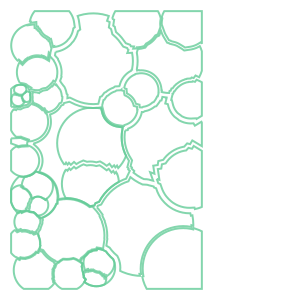

In [74]:
n_fails = 0
n_iters = 0
while (n_fails < 10) and (n_iters < iter_max):
    try:
        n_iters += 1
        fc_rad = gp.get_rad(circle_to_fill)
        rads = np.linspace(fc_rad*0.5, fc_rad*0.3, 15)
        rads[rads<min_rad] = min_rad
        circles = gp.circle_pack_within_poly(circle_to_fill, rads, progress_bar=False)
        if circles.type == 'MultiPolygon':
            circles =gp.nuzzle_em(circles, prms, n_iters=20)
            circle_to_fill.filled = True
            circles = circles.intersection(circle_to_fill)
            all_circles += [c.buffer(-0.) for c in circles]
        not_yet_filled = [c for c in all_circles if not getattr(c, 'filled', False)]
        areas = np.array([c.area for c in not_yet_filled])
        areas = areas/areas.sum()
        circle_to_fill = np.random.choice(not_yet_filled, p=areas)
        n_fails = 0
    except:
        n_fails += 1
MultiPolygon(all_circles).boundary

In [75]:
bottom_level_circles = [c for c in all_circles if not getattr(c, 'filled', False)]

In [76]:
blcb = MultiPolygon(bottom_level_circles).buffer(-0.5).boundary

In [77]:
fill_circles = []
for c in all_circles:
    if not getattr(c, 'filled', False):
        
        rad = gp.get_rad(c)
        if rad > 0.5:
            _c = c.buffer(-0.5)
            spacing = np.random.uniform(-0.5, -1)
            erodes = np.arange(spacing, -rad+0.5, spacing)
    #         erodes *= (np.random.randn(*erodes.shape) * 0.01 + 1)
            fill_circles += [_c.buffer(b) for b in erodes]

fills = MultiPolygon(fill_circles).boundary

In [78]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('1mm')



sk.stroke(1)
sk.geometry(blcb)
sk.stroke(2)
sk.geometry(fills)

for tol in [0.2, 0.4, 0.8, 1.]:
    sk.vpype(f'linesimplify -t {tol}mm linemerge -t {tol}mm')

sk.vpype('linesort')

sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-31T12:01:11.455864 
 
 
 
 
 
 
 <polygon points="1048.622,1700.305 1036.9792,1700.0526 1035.4195,1706.2792 1041.1706,1765.9854 1035.4195,1825.8771 1043.0767,1850.2622 1095.1751,1860.2664 1109.6703,1879.6743 1153.6238,1911.3393 1175.2423,1937.6774 1195.7398,1947.5311 1206.7053,1977.7506 1250.0109,1895.6259 1313.273,1875.7485 1372.8889,1839.4647 1442.9877,1851.6151 1484.207,1869.9313 1497.78,1835.8279 1497.8268,1696.5152 1479.5632,1652.4065 1454.08,1663.9847 1440.2118,1646.0057 1425.627,1649.4289 1418.9925,1642.5831 1392.884,1641.2642 1347.0417,1623.0674 1316.3723,1603.1186 1289.3513,1572.2089 1280.5671,1570.4723 1263.3907,1538.7101 1213.6863,1545.309 1200.9861,1610.7884 1178.9256,1647.594 1158.4395,1668.0801 1107.891,1695.0578"/>
 
 
 <polygon points="951.5126,1266.2499 969.675,1269.1696 972.7188,1279.5559 1003.2798,1295.3713 1037.6764,1326.5466 1061.6598,1366.5076 1071.0065,1398.2004 1123.6157,1413.6036 1174.6332,1440.4873 1202.4366,1480.0874 1212.0897,1482.2177 1218.268,1506.5484 1242.782,1502.9957 1235.6679,1460.3082 1254.1833,1455.0998 1280.1446,1391.4076 1301.6154,1365.3256 1334.8328,1339.2682 1387.5067,1319.6706 1438.6002,1317.2885 1449.6442,1300.4963 1495.8333,1327.8097 1497.8268,1158.9087 1431.0655,1198.4238 1414.5863,1172.2738 1393.7121,1177.1742 1372.0363,1153.5909 1301.4552,1129.5857 1263.4481,1104.1683 1221.7068,1059.1188 1186.325,1050.0261 1181.7184,1021.8943 1149.6744,1016.5815 1157.4068,960.6817 1126.7063,969.0768 1147.5638,910.3571 1084.7817,921.1673 1012.0657,966.2945 1016.9657,978.2706 998.1878,995.4841 1000.3786,1003.2502 990.8003,1012.1257 1001.1985,1054.2298 968.1733,1114.7432 952.5575,1166.2217 947.2847,1219.7577"/>
 
 <polygon points="750.4348,716.1127 755.5945,727.0219 779.3772,735.7685 820.3741,797.9934 865.5932,843.2125 918.7654,878.741 974.4258,902.0757 988.1892,930.6542 1073.8262,878.948 1152.9913,864.8239 1155.9773,857.4238 1170.3379,852.1991 1202.4097,784.1194 1233.9656,746.2799 1271.8281,714.7522 1338.563,683.2191 1415.4599,672.6066 1419.938,655.6475 1430.4178,657.2428 1436.4954,586.9524 1423.7187,590.7902 1422.2905,578.8367 1335.9967,582.7374 1277.0284,571.0264 1221.4778,548.0362 1171.4797,514.6505 1128.838,472.0087 1082.5926,394.8001 1065.1581,337.2636 1061.6803,241.23 1050.9076,240.7591 1053.5775,227.8219 1001.4998,233.8873 915.9911,262.7429 913.7821,318.9604 895.4985,369.3139 839.9552,429.3422 817.0202,443.1312 824.1333,491.1456 817.7265,571.6209 806.0577,619.151 788.7911,655.6794 789.9351,665.5616"/>
 <polygon points="517.9413,972.3169 528.5001,987.8163 536.6367,977.7745 549.2092,993.0495 559.457,983.4799 583.2975,1004.8935 597.5178,993.1384 651.3947,1022.9295 673.8391,1014.9373 713.8837,1016.957 743.1623,1010.9693 765.3395,1016.4405 816.8665,980.6664 831.5512,990.5116 851.1008,964.5265 864.1895,974.8149 874.6801,958.1468 884.2265,966.9424 894.9701,944.4587 902.9615,900.6475 822.7561,840.6994 761.1157,757.5831 736.2784,748.6097 728.0645,731.7648 697.2381,727.1921 658.5076,752.6614 609.7908,772.8405 525.6162,784.2136 506.9227,826.7458 498.1922,885.6023 502.0881,925.1576"/>
 <polygon points="515.6756,1024.2049 483.4793,1079.8506 469.0615,1127.3795 464.1932,1176.8079 469.0615,1226.2364 483.4793,1273.7653 506.8924,1317.5682 538.4012,1355.9618 576.7948,1387.4706 620.5977,1410.8837 668.1266,1425.3014 747.003,1428.2653 776.7864,1422.8459 795.6026,1363.6704 829.0652,1322.8391 875.6061,1297.9214 930.1307,1288.4994 924.2927,1190.3724 935.6863,1133.093 954.231,1087.1176 928.2176,1036.0477 900.556,1001.8988 891.8507,1018.3403 879.8939,1006.3987 870.7163,1020.0771 855.9689,1007.4579 837.6008,1031.2953 817.5032,1017.0789 769.8502,1048.1118 743.2551,1041.5339 676.9272,1045.3456 649.8246,1054.8903 600.4533,1029.4381 583.2048,1044.3242 560.7507,1024.5519 547.1503,1038.7335 536.914,1026.3414 525.9505,1039.714"/>
 
 
 
 
 
 
 <polygon points="328.1002,522.48 330.9654,541.7956 343.9387,559.2186 357.6815,597.9447 362.2746,626.2391 358.777

In [79]:
sk.save('/mnt/c/code/side/plotter_images/oned_outputs/260_any_shape_none_touch_flaws.svg')